<a href="https://colab.research.google.com/github/MISJasonChuang/EDD_ELM/blob/main/OS_ELM_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#  --quiet hide code cell output
!pip install statsmodels --quiet
!pip install river

In [2]:
"""Module to build Extreme Learning Machine (ELM) models"""

# ===================================================
# Acknowledgement:
# Author: David C. Lambert [dcl -at- panix -dot- com]
# Copyright(c) 2013
# License: Simple BSD
# ===================================================

from abc import ABCMeta, abstractmethod

import numpy as np
from scipy.special import softmax
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import as_float_array


__all__ = [
    "ELMRegressor",
    "ELMClassifier",
    "GenELMRegressor",
    "GenELMClassifier",
]


class BaseELM(BaseEstimator):
    """Abstract Base class for ELMs"""
    __metaclass__ = ABCMeta

    def __init__(self, hidden_layer, regressor):
        self.regressor = regressor
        self.hidden_layer = hidden_layer

    @abstractmethod
    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object
            Returns an instance of self.
        """

    @abstractmethod
    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """


class GenELMRegressor(BaseELM, RegressorMixin):
    """
    Regression model based on Extreme Learning Machine.

    Parameters
    ----------
    `hidden_layer` : random_layer instance, optional
        (default=MLPRandomLayer(random_state=0))

    `regressor`    : regressor instance, optional
        (default=sklearn.linear_model.LinearRegression())

    Attributes
    ----------
    `coefs_` : numpy array
        Fitted regression coefficients if no regressor supplied.

    `fitted_` : bool
        Flag set when fit has been called already.

    `hidden_activations_` : numpy array of shape [n_samples, n_hidden]
        Hidden layer activations for last input.

    See Also
    --------
    ELMRegressor, MLPRandomLayer
    """

    def __init__(self, hidden_layer=None, regressor=None):
        if hidden_layer is None:
            # Default value
            hidden_layer = MLPRandomLayer(random_state=0)
        elif not isinstance(hidden_layer, RandomLayer):
            raise ValueError("Argument 'hidden_layer' must be a RandomLayer instance")

        if regressor is None:
            # Default value
            regressor = LinearRegression()
        elif not isinstance(regressor, RegressorMixin):
            raise ValueError("Argument 'regressor' must be a RegressorMixin instance")

        super(GenELMRegressor, self).__init__(hidden_layer, regressor)

        self.coefs_ = None
        self.fitted_ = False
        self.hidden_activations_ = None

    def _fit_regression(self, y):
        """Fit regression with the supplied regressor"""
        self.regressor.fit(self.hidden_activations_, y)
        self.fitted_ = True

    @property
    def is_fitted(self):
        """Check if model was fitted

        Returns
        -------
            boolean, True if model is fitted
        """
        return self.fitted_

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        # fit random hidden layer and compute the hidden layer activations
        self.hidden_activations_ = self.hidden_layer.fit_transform(X)

        # solve the regression from hidden activations to outputs
        self._fit_regression(as_float_array(y, copy=True))

        return self

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if not self.is_fitted:
            raise ValueError("GenELMRegressor not fitted")

        # compute hidden layer activations
        self.hidden_activations_ = self.hidden_layer.transform(X)

        # compute output predictions for new hidden activations
        predictions = self.regressor.predict(self.hidden_activations_)

        return predictions


class GenELMClassifier(BaseELM, ClassifierMixin):
    """
    Classification model based on Extreme Learning Machine.
    Internally, it uses a GenELMRegressor.

    Parameters
    ----------
    `hidden_layer` : random_layer instance, optional
        (default=MLPRandomLayer(random_state=0))

    `binarizer`    : LabelBinarizer, optional
        (default=sklearn.preprocessing.LabelBinarizer(-1, 1))

    `regressor`    : regressor instance, optional
        (default=LinearRegression())
        Used to perform the regression from hidden unit activations
        to the outputs and subsequent predictions.

    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels

    `genelm_regressor_` : ELMRegressor instance
        Performs actual fit of binarized values

    See Also
    --------
    GenELMRegressor, ELMClassifier, MLPRandomLayer
    """
    def __init__(self, hidden_layer=None, binarizer=None, regressor=None):

        # Default values
        if hidden_layer is None:
            hidden_layer = MLPRandomLayer(random_state=0)
        if binarizer is None:
            binarizer = LabelBinarizer(neg_label=-1, pos_label=1)

        super(GenELMClassifier, self).__init__(hidden_layer, regressor)

        self.binarizer = binarizer

        self.classes_ = None
        self._genelm_regressor = GenELMRegressor(hidden_layer, regressor)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        self.classes_ = np.unique(y)

        y_bin = self.binarizer.fit_transform(y)

        self._genelm_regressor.fit(X, y_bin)
        return self

    @property
    def is_fitted(self):
        """Check if model was fitted

        Returns
        -------
            boolean, True if model is fitted
        """
        return self._genelm_regressor is not None and self._genelm_regressor.is_fitted

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        if not self.is_fitted:
            raise ValueError("GenELMClassifier not fitted")

        return self._genelm_regressor.predict(X)

    def predict(self, X):
        """Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if not self.is_fitted:
            raise ValueError("GenELMClassifier not fitted")

        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions


class ELMRegressor(BaseEstimator, RegressorMixin):
    """
    Regression model based on Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    ELMRegressor is a wrapper for an GenELMRegressor that creates a
    RandomLayer based on the given parameters.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer

    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation

    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation

    `activation_func` : {callable, string} optional (default='sigmoid')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribas', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that woud otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_hidden, n_features]

    `regressor`    : regressor instance, optional
        (default=sklearn.linear_model.LinearRegression())
        Used to perform the regression from hidden unit activations
        to the outputs and subsequent predictions.

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `genelm_regressor_` : GenELMRegressor object
        Wrapped object that actually performs the fit.

    Examples
    --------
    >>> from pyoselm import ELMRegressor
    >>> from sklearn.datasets import make_regression
    >>> X, y = make_regression(n_samples=100, n_targets=1, n_features=10)
    >>> model = ELMRegressor(n_hidden=20,
    ...                      activation_func="tanh",
    ...                      random_state=123)
    >>> model.fit(X, y)
    ELMRegressor(random_state=123)
    >>> model.score(X, y)
    0.8600650083210614

    See Also
    --------
    GenELMRegressor, RandomLayer, MLPRandomLayer,

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self,
                 n_hidden=20,
                 alpha=0.5,
                 rbf_width=1.0,
                 activation_func='sigmoid',
                 activation_args=None,
                 user_components=None,
                 regressor=None,
                 random_state=None,):

        self.n_hidden = n_hidden
        self.alpha = alpha
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args
        self.user_components = user_components
        self.rbf_width = rbf_width
        self.regressor = regressor

        # Just to validate input arguments
        self._create_random_layer()

        self._genelm_regressor = None

    def _create_random_layer(self):
        """Pass init params to RandomLayer"""

        return RandomLayer(n_hidden=self.n_hidden,
                           alpha=self.alpha, random_state=self.random_state,
                           activation_func=self.activation_func,
                           activation_args=self.activation_args,
                           user_components=self.user_components,
                           rbf_width=self.rbf_width)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        rhl = self._create_random_layer()
        self._genelm_regressor = GenELMRegressor(hidden_layer=rhl,
                                                 regressor=self.regressor)
        self._genelm_regressor.fit(X, y)
        return self

    @property
    def is_fitted(self):
        """Check if model was fitted

        Returns
        -------
            boolean, True if model is fitted
        """
        return self._genelm_regressor is not None and self._genelm_regressor.is_fitted

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if not self.is_fitted:
            raise ValueError("ELMRegressor is not fitted")

        return self._genelm_regressor.predict(X)


# TODO: inherit from BaseELMClassifier
class ELMClassifier(ELMRegressor):
    """
    Classification model based on Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    ELMClassifier is an ELMRegressor subclass that first binarizes the
    data, then uses the superclass to compute the decision function that
    is then unbinarized to yield the prediction.

    The params for the RandomLayer used in the input transform are
    exposed in the ELMClassifier constructor.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer

    `activation_func` : {callable, string} optional (default='sigmoid')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribas', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable. If a callable is given, it will be used to compute
        the hidden unit activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels

    Examples
    --------
    >>> from pyoselm import ELMClassifier
    >>> from sklearn.datasets import load_digits
    >>> X, y = load_digits(n_class=10, return_X_y=True)
    >>> model = ELMClassifier(n_hidden=50,
    ...                       activation_func="sigmoid",
    ...                       random_state=123)
    >>> model.fit(X, y)
    ELMClassifier(activation_func='sigmoid', n_hidden=50, random_state=123)
    >>> model.score(X, y)
    0.8241513633834168

    See Also
    --------
    RandomLayer, RBFRandomLayer, MLPRandomLayer,
    GenELMRegressor, GenELMClassifier, ELMClassifier

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self,
                 n_hidden=20,
                 alpha=0.5,
                 rbf_width=1.0,
                 activation_func='sigmoid',
                 activation_args=None,
                 user_components=None,
                 regressor=None,
                 binarizer=LabelBinarizer(neg_label=-1, pos_label=1),
                 random_state=None,):

        super(ELMClassifier, self).__init__(n_hidden=n_hidden,
                                            alpha=alpha,
                                            random_state=random_state,
                                            activation_func=activation_func,
                                            activation_args=activation_args,
                                            user_components=user_components,
                                            rbf_width=rbf_width,
                                            regressor=regressor)

        self.classes_ = None
        self.binarizer = binarizer

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        self.classes_ = np.unique(y)

        y_bin = self.binarizer.fit_transform(y)
        super(ELMClassifier, self).fit(X, y_bin)

        return self

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        if not self.is_fitted:
            raise ValueError("ELMClassifier is not fitted")

        return super(ELMClassifier, self).predict(X)

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if not self.is_fitted:
            raise ValueError("ELMClassifier is not fitted")

        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions

    def predict_proba(self, X):
        """
        Predict probability values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        P : numpy array of shape [n_samples, n_outputs]
            Predicted probability values.
        """
        if not self.is_fitted:
            raise ValueError("ELMClassifier not fitted")

        raw_predictions = self.decision_function(X)
        # using softmax to translate raw predictions into probability values
        proba_predictions = softmax(raw_predictions)

        return proba_predictions

    def score(self, X, y, **kwargs):
        """Force use of accuracy score since
        it doesn't inherit from ClassifierMixin"""
        return accuracy_score(y, self.predict(X))

In [3]:
"""Module to provide random layers for ELM and OS-ELM models"""

# ===================================================
# Acknowledgement:
# Author: David C. Lambert [dcl -at- panix -dot- com]
# Copyright(c) 2013
# License: Simple BSD
# ===================================================

from abc import ABCMeta, abstractmethod
from math import sqrt

import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import safe_sparse_dot


__all__ = [
    "RandomLayer",
    "MLPRandomLayer",
    "RBFRandomLayer",
    "GRBFRandomLayer",
]


class BaseRandomLayer(BaseEstimator, TransformerMixin):
    """Abstract Base class for random layers"""
    __metaclass__ = ABCMeta

    _internal_activation_funcs = dict()

    @classmethod
    def activation_func_names(cls):
        """Get list of internal activation function names"""
        return cls._internal_activation_funcs.keys()

    def __init__(self,
                 n_hidden=20,
                 random_state=0,
                 activation_func=None,
                 activation_args=None,):

        self.n_hidden = n_hidden
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args

        self.components_ = dict()
        self.input_activations_ = None

        # keyword args for internally defined funcs
        self._extra_args = dict()

    @abstractmethod
    def _generate_components(self, X):
        """Generate components of hidden layer given X"""

    @abstractmethod
    def _compute_input_activations(self, X):
        """Compute input activations given X"""

    def _compute_hidden_activations(self, X):
        """Compute hidden activations given X"""
        # compute input activations and pass them
        # through the hidden layer transfer functions
        # to compute the transform

        self._compute_input_activations(X)

        acts = self.input_activations_

        if callable(self.activation_func):
            args_dict = self.activation_args if self.activation_args else {}
            X_new = self.activation_func(acts, **args_dict)
        else:
            func_name = self.activation_func
            func = self._internal_activation_funcs[func_name]
            X_new = func(acts, **self._extra_args)

        return X_new

    def fit(self, X, y=None):
        """Generate a random hidden layer.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training set: only the shape is used to generate random component
            values for hidden units

        y : not used: placeholder to allow for usage in a Pipeline.

        Returns
        -------
        self
        """
        # perform fit by generating random components based
        # on the input array
        X = check_array(X, accept_sparse=True)
        self._generate_components(X)

        return self

    def transform(self, X, y=None):
        """Generate the random hidden layer's activations given X as input.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape [n_samples, n_features]
            Data to transform

        y : not used: placeholder to allow for usage in a Pipeline.

        Returns
        -------
        X_new : numpy array of shape [n_samples, n_components]
        """
        # perform transformation by calling compute_hidden_activations
        # (which will normally call compute_input_activations first)
        X = check_array(X, accept_sparse=True)

        if len(self.components_) == 0:
            raise ValueError('No components initialized')

        return self._compute_hidden_activations(X)


class RandomLayer(BaseRandomLayer):
    """RandomLayer is a transformer that creates a feature mapping of the
    inputs that corresponds to a layer of hidden units with randomly
    generated components.

    The transformed values are a specified function of input activations
    that are a weighted combination of dot product (multilayer perceptron)
    and distance (rbf) activations:

      input_activation = alpha * mlp_activation + (1-alpha) * rbf_activation

      mlp_activation(x) = dot(x, weights) + bias
      rbf_activation(x) = rbf_width * ||x - center||/radius

      alpha and rbf_width are specified by the user

      weights and biases are taken from normal distribution of
      mean 0 and sd of 1

      centers are taken uniformly from the bounding hyperrectangle
      of the inputs, and radii are max(||x-c||)/sqrt(n_centers*2)

    The input activation is transformed by a transfer function that defaults
    to numpy.tanh if not specified, but can be any callable that returns an
    array of the same shape as its argument (the input activation array, of
    shape [n_samples, n_hidden]).  Functions provided are 'sine', 'tanh',
    'tribas', 'inv_tribas', 'sigmoid', 'hardlim', 'softlim', 'gaussian',
    'multiquadric', or 'inv_multiquadric'.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate

    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation

    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation

    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that would otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_features, n_hidden]

    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribas',
        'sigmoid', 'hardlim', 'softlim', 'gaussian', 'multiquadric',
        'inv_multiquadric' or a callable.  If None is given, 'tanh'
        will be used.

        If a callable is given, it will be used to compute the activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `input_activations_` : numpy array of shape [n_samples, n_hidden]
        Array containing dot(x, hidden_weights) + bias for all samples

    `components_` : dictionary containing two keys:
        `bias_weights_`   : numpy array of shape [n_hidden]
        `hidden_weights_` : numpy array of shape [n_features, n_hidden]

    See Also
    --------
    """

    # triangular activation function
    _tribas = lambda x: np.clip(1.0 - np.fabs(x), 0.0, 1.0)

    # inverse triangular activation function
    _inv_tribas = lambda x: np.clip(np.fabs(x), 0.0, 1.0)

    # sigmoid activation function
    _sigmoid = lambda x: 1.0/(1.0 + np.exp(-x))

    # hard limit activation function
    _hardlim = lambda x: np.array(x > 0.0, dtype=float)

    _softlim = lambda x: np.clip(x, 0.0, 1.0)

    # identity or linear activation function
    _linear = lambda x: x

    # ReLU
    _relu = lambda x: np.maximum(x, 0)

    # Softplus activation function
    _softplus = lambda x: np.log(1.0 + np.exp(x))

    # gaussian RBF
    _gaussian = lambda x: np.exp(-pow(x, 2.0))

    # multiquadric RBF
    _multiquadric = lambda x: np.sqrt(1.0 + pow(x, 2.0))

    # inverse multiquadric RBF
    _inv_multiquadric = lambda x: 1.0/(np.sqrt(1.0 + pow(x, 2.0)))

    # internal activation function table
    _internal_activation_funcs = {
        'sine': np.sin,
        'tanh': np.tanh,
        'tribas': _tribas,
        'inv_tribas': _inv_tribas,
        'linear': _linear,
        'relu': _relu,
        'softplus': _softplus,
        'sigmoid': _sigmoid,
        'softlim': _softlim,
        'hardlim': _hardlim,
        'gaussian': _gaussian,
        'multiquadric': _multiquadric,
        'inv_multiquadric': _inv_multiquadric,
    }

    def __init__(self,
                 n_hidden=20,
                 alpha=0.5,
                 random_state=None,
                 activation_func='tanh',
                 activation_args=None,
                 user_components=None,
                 rbf_width=1.0,):

        super(RandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args
        )

        if isinstance(self.activation_func, str):
            func_names = self._internal_activation_funcs.keys()
            if self.activation_func not in func_names:
                msg = "Unknown activation function '%s'" % self.activation_func
                raise ValueError(msg)

        self.alpha = alpha
        self.rbf_width = rbf_width
        self.user_components = user_components

        self._use_mlp_input = (self.alpha != 0.0)
        self._use_rbf_input = (self.alpha != 1.0)

    def _get_user_components(self, key):
        """Look for given user component"""
        try:
            return self.user_components[key]
        except (TypeError, KeyError):
            return None

    def _compute_radii(self):
        """Generate RBF radii"""

        # use supplied radii if present
        radii = self._get_user_components('radii')

        # compute radii
        if radii is None:
            centers = self.components_['centers']

            n_centers = centers.shape[0]
            max_dist = np.max(pairwise_distances(centers))
            radii = np.ones(n_centers) * max_dist/sqrt(2.0 * n_centers)

        self.components_['radii'] = radii

    def _compute_centers(self, X, sparse, rs):
        """Generate RBF centers"""

        # use supplied centers if present
        centers = self._get_user_components('centers')

        # use points taken uniformly from the bounding hyperrectangle
        if centers is None:
            n_features = X.shape[1]

            if sparse:
                cols = [X.getcol(i) for i in range(n_features)]

                min_dtype = X.dtype.type(1.0e10)
                sp_min = lambda col: np.minimum(min_dtype, np.min(col.data))
                min_Xs = np.array(list(map(sp_min, cols)))

                max_dtype = X.dtype.type(-1.0e10)
                sp_max = lambda col: np.maximum(max_dtype, np.max(col.data))
                max_Xs = np.array(list(map(sp_max, cols)))
            else:
                min_Xs = X.min(axis=0)
                max_Xs = X.max(axis=0)

            spans = max_Xs - min_Xs
            ctrs_size = (self.n_hidden, n_features)
            centers = min_Xs + spans * rs.uniform(0.0, 1.0, ctrs_size)

        self.components_['centers'] = centers

    def _compute_biases(self, rs):
        """Generate MLP biases"""

        # use supplied biases if present
        biases = self._get_user_components('biases')
        if biases is None:
            b_size = self.n_hidden
            biases = rs.normal(size=b_size)

        self.components_['biases'] = biases

    def _compute_weights(self, X, rs):
        """Generate MLP weights"""

        # use supplied weights if present
        weights = self._get_user_components('weights')
        if weights is None:
            n_features = X.shape[1]
            hw_size = (n_features, self.n_hidden)
            weights = rs.normal(size=hw_size)

        self.components_['weights'] = weights

    def _generate_components(self, X):
        """Generate components of hidden layer given X"""

        rs = check_random_state(self.random_state)
        if self._use_mlp_input:
            self._compute_biases(rs)
            self._compute_weights(X, rs)

        if self._use_rbf_input:
            self._compute_centers(X, sp.issparse(X), rs)
            self._compute_radii()

    def _compute_input_activations(self, X):
        """Compute input activations given X"""

        n_samples = X.shape[0]

        mlp_acts = np.zeros((n_samples, self.n_hidden))
        if self._use_mlp_input:
            b = self.components_['biases']
            w = self.components_['weights']
            mlp_acts = self.alpha * (safe_sparse_dot(X, w) + b)

        rbf_acts = np.zeros((n_samples, self.n_hidden))
        if self._use_rbf_input:
            radii = self.components_['radii']
            centers = self.components_['centers']
            scale = self.rbf_width * (1.0 - self.alpha)

            if sp.issparse(X):
                X = X.todense()

            rbf_acts = scale * cdist(X, centers)/radii

        self.input_activations_ = mlp_acts + rbf_acts


class MLPRandomLayer(RandomLayer):
    """Wrapper for RandomLayer with alpha (mixing coefficient) set
       to 1.0 for MLP activations only"""

    def __init__(self, n_hidden=20, random_state=None,
                 activation_func='tanh', activation_args=None,
                 weights=None, biases=None):

        user_components = {'weights': weights, 'biases': biases}
        super(MLPRandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args,
            user_components=user_components,
            alpha=1.0
        )


class RBFRandomLayer(RandomLayer):
    """Wrapper for RandomLayer with alpha (mixing coefficient) set
       to 0.0 for RBF activations only"""

    def __init__(self, n_hidden=20, random_state=None,
                 activation_func='gaussian', activation_args=None,
                 centers=None, radii=None, rbf_width=1.0):

        user_components = {'centers': centers, 'radii': radii}
        super(RBFRandomLayer, self).__init__(
            n_hidden=n_hidden,
            random_state=random_state,
            activation_func=activation_func,
            activation_args=activation_args,
            user_components=user_components,
            rbf_width=rbf_width,
            alpha=0.0
        )


class GRBFRandomLayer(RBFRandomLayer):
    """Random Generalized RBF Hidden Layer transformer

    Creates a layer of radial basis function units where:

       f(a), s.t. a = ||x-c||/r

    with c the unit center
    and f() is exp(-gamma * a^tau) where tau and r are computed
    based on [1]

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate, ignored if centers are provided

    `grbf_lambda` : float, optional (default=0.05)
        GRBF shape parameter

    `gamma` : {int, float} optional (default=1.0)
        Width multiplier for GRBF distance argument

    `centers` : array of shape (n_hidden, n_features), optional (default=None)
        If provided, overrides internal computation of the centers

    `radii` : array of shape (n_hidden),  optional (default=None)
        If provided, overrides internal computation of the radii

    `use_exemplars` : bool, optional (default=False)
        If True, uses random examples from the input to determine the RBF
        centers, ignored if centers are provided

    `random_state`  : int or RandomState instance, optional (default=None)
        Control the pseudo random number generator used to generate the
        centers at fit time, ignored if centers are provided

    Attributes
    ----------
    `components_` : dictionary containing two keys:
        `radii_`   : numpy array of shape [n_hidden]
        `centers_` : numpy array of shape [n_hidden, n_features]

    `input_activations_` : numpy array of shape [n_samples, n_hidden]
        Array containing ||x-c||/r for all samples

    See Also
    --------
    ELMRegressor, ELMClassifier, SimpleELMRegressor, SimpleELMClassifier,
    SimpleRandomLayer

    References
    ----------
    .. [1] Fernandez-Navarro, et al, "MELM-GRBF: a modified version of the
              extreme learning machine for generalized radial basis function
              neural networks", Neurocomputing 74 (2011), 2502-2510

    """

    def __init__(self, n_hidden=20, grbf_lambda=0.001,
                 centers=None, radii=None, random_state=None):

        self._internal_activation_funcs = {'grbf': self._grbf}

        super(GRBFRandomLayer, self).__init__(
            n_hidden=n_hidden,
            activation_func='grbf',
            centers=centers, radii=radii,
            random_state=random_state
        )

        self.grbf_lambda = grbf_lambda
        self.dN_vals = None
        self.dF_vals = None
        self.tau_vals = None

    @staticmethod
    def _grbf(acts, taus):
        """GRBF activation function"""
        return np.exp(np.exp(-pow(acts, taus)))

    def _compute_centers(self, X, sparse, rs):
        """Generate centers, then compute tau, dF and dN vals"""
        # get centers from superclass, then calculate tau_vals
        # according to ref [1]
        super(GRBFRandomLayer, self)._compute_centers(X, sparse, rs)

        centers = self.components_['centers']
        sorted_distances = np.sort(squareform(pdist(centers)))
        self.dF_vals = sorted_distances[:, -1]
        self.dN_vals = sorted_distances[:, 1]/100.0

        tauNum = np.log(np.log(self.grbf_lambda) /
                        np.log(1.0 - self.grbf_lambda))

        tauDenom = np.log(self.dF_vals/self.dN_vals)

        self.tau_vals = tauNum/tauDenom

        self._extra_args['taus'] = self.tau_vals

    def _compute_radii(self):
        """Generate radii"""
        # according to ref [1]
        denom = pow(-np.log(self.grbf_lambda), 1.0/self.tau_vals)
        self.components_['radii'] = self.dF_vals/denom

In [4]:
"""Module to build Online Sequential Extreme Learning Machine (OS-ELM) models"""

# ===================================================
# Author: Leandro Ferrado
# Copyright(c) 2018
# License: Apache License 2.0
# ===================================================

import warnings

import numpy as np
from scipy.linalg import pinv
from scipy.sparse import eye
from scipy.special import softmax
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import as_float_array
from sklearn.utils.extmath import safe_sparse_dot


__all__ = [
    "OSELMRegressor",
    "OSELMClassifier",
]


def multiple_safe_sparse_dot(*matrices):
    """
    Make safe_sparse_dot() calls over multiple matrices

    Parameters
    ----------
    matrices: iterable of matrices

    Returns
    -------
    dot_product : array or sparse matrix
    """
    if len(matrices) < 2:
        raise ValueError("Argument 'matrices' must have at least 2 matrices")

    r = matrices[0]
    for m in matrices[1:]:
        r = safe_sparse_dot(r, m)

    return r


class OSELMRegressor(BaseEstimator, RegressorMixin):
    """
    OSELMRegressor is a regressor based on Online Sequential
    Extreme Learning Machine (OS-ELM).

    This type of model is an ELM that....   ...
    [1][2]

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer

    `activation_func` : {callable, string} optional (default='sigmoid')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribas', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `use_woodbury`  : bool, optional (default=False)
        Flag to indicate if Woodbury formula should be used for the fit
        step, or just the traditional iterative procedure. Not recommended if
        handling large datasets.

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `P` : np.array
        ...

    `beta` : np.array
    ...

    See Also
    --------
    ELMRegressor, MLPRandomLayer

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.

    """
    def __init__(self,
                 n_hidden=20,
                 activation_func='sigmoid',
                 activation_args=None,
                 use_woodbury=False,
                 random_state=123,):
        self.n_hidden = n_hidden
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args
        self.use_woodbury = use_woodbury

        self.P = None
        self.beta = None

    def _create_random_layer(self):
        """Pass init params to MLPRandomLayer"""

        return MLPRandomLayer(n_hidden=self.n_hidden,
                              random_state=self.random_state,
                              activation_func=self.activation_func,
                              activation_args=self.activation_args)

    def _fit_woodbury(self, X, y):
        """Compute learning step using Woodbury formula"""
        # fit random hidden layer and compute the hidden layer activations
        H = self._create_random_layer().fit_transform(X)
        y = as_float_array(y, copy=True)

        if self.beta is None:
            # this is the first time the model is fitted
            if len(X) < self.n_hidden:
                raise ValueError("The first time the model is fitted, "
                                 "X must have at least equal number of "
                                 "samples than n_hidden value!")
            self.P = pinv(safe_sparse_dot(H.T, H))
            self.beta = multiple_safe_sparse_dot(self.P, H.T, y)
        else:
            if len(H) > 10e3:
                warnings.warn("Large input of %i rows and use_woodbury=True "\
                              "may throw OOM errors" % len(H))

            M = eye(len(H)) + multiple_safe_sparse_dot(H, self.P, H.T)
            self.P -= multiple_safe_sparse_dot(self.P, H.T, pinv(M), H, self.P)
            e = y - safe_sparse_dot(H, self.beta)
            self.beta += multiple_safe_sparse_dot(self.P, H.T, e)

    def _fit_iterative(self, X, y):
        """Compute learning step using iterative procedure"""
        # fit random hidden layer and compute the hidden layer activations
        H = self._create_random_layer().fit_transform(X)
        y = as_float_array(y, copy=True)

        if self.beta is None:
            # this is the first time the model is fitted
            print("Batch learning...\n")
            if len(X) < self.n_hidden:
                raise ValueError("The first time the model is fitted, "
                                 "X must have at least equal number of "
                                 "samples than n_hidden value!")

            self.P = safe_sparse_dot(H.T, H)
            P_inv = pinv(self.P)
            self.beta = multiple_safe_sparse_dot(P_inv, H.T, y)
        else:
            print("Online learning...\n")
            self.P += safe_sparse_dot(H.T, H)
            P_inv = pinv(self.P)
            e = y - safe_sparse_dot(H, self.beta)
            self.beta = self.beta + multiple_safe_sparse_dot(P_inv, H.T, e)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Notice that this function could be used for n_samples==1 (online learning),
        except for the first time the model is fitted, where it needs at least as
        many rows as 'n_hidden' configured.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        if self.use_woodbury:
            self._fit_woodbury(X, y)
        else:
            self._fit_iterative(X, y)

        return self

    def partial_fit(self, X, y):
        """
        Fit the model using X, y as training data. Alias for fit() method.

        Notice that this function could be used for n_samples==1 (online learning),
        except for the first time the model is fitted, where it needs at least as
        many rows as 'n_hidden' configured.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        return self.fit(X, y)

    @property
    def is_fitted(self):
        """Check if model was fitted

        Returns
        -------
            boolean, True if model is fitted
        """
        return self.beta is not None

    def predict(self, X):
        """
        Predict values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if not self.is_fitted:
            raise ValueError("OSELMRegressor not fitted")

        # compute hidden layer activations
        H = self._create_random_layer().fit_transform(X)

        # compute output predictions for new hidden activations
        predictions = safe_sparse_dot(H, self.beta)

        return predictions


class OSELMClassifier(OSELMRegressor):
    """
    OSELMClassifier is a classifier based on the Extreme Learning Machine.

    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]

    OSELMClassifier is an OSELMRegressor subclass that first binarizes the
    data, then uses the superclass to compute the decision function that
    is then unbinarized to yield the prediction.

    The params for the RandomLayer used in the input transform are
    exposed in the ELMClassifier constructor.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer

    `activation_func` : {callable, string} optional (default='sigmoid')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribas', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels

    See Also
    --------
    ELMRegressor, OSELMRegressor, MLPRandomLayer

    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self,
                 n_hidden=20,
                 activation_func='sigmoid',
                 activation_args=None,
                 binarizer=LabelBinarizer(neg_label=-1, pos_label=1),
                 use_woodbury=False,
                 random_state=123):

        super(OSELMClassifier, self).__init__(n_hidden=n_hidden,
                                              random_state=random_state,
                                              activation_func=activation_func,
                                              activation_args=activation_args,
                                              use_woodbury=use_woodbury)
        self.classes_ = None
        self.binarizer = binarizer

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]

        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        return super(OSELMClassifier, self).predict(X)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.

        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)

        Returns
        -------
        self : object

            Returns an instance of self.
        """
        if not self.is_fitted:
            self.classes_ = np.unique(y)
            y_bin = self.binarizer.fit_transform(y)
        else:
            y_bin = self.binarizer.transform(y)

        super(OSELMClassifier, self).fit(X, y_bin)

        return self

    def predict(self, X):
        """
        Predict class values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted class values.
        """
        if not self.is_fitted:
            raise ValueError("OSELMClassifier not fitted")

        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions

    def predict_proba(self, X):
        """
        Predict probability values using the model

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]

        Returns
        -------
        P : numpy array of shape [n_samples, n_outputs]
            Predicted probability values.
        """
        if not self.is_fitted:
            raise ValueError("OSELMClassifier not fitted")

        raw_predictions = self.decision_function(X)
        # using softmax to translate raw predictions into probability values
        proba_predictions = softmax(raw_predictions)

        return proba_predictions

    def score(self, X, y, **kwargs):
        """Force use of accuracy score since
        it doesn't inherit from ClassifierMixin"""
        return accuracy_score(y, self.predict(X))

In [5]:
%%capture
# hide code cell output
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# from elm import ELMRegressor
from collections.abc import Iterable, Generator
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pylab as py
import random
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
# from skmultiflow.drift_detection import DDM
# from river import drift
import statsmodels.api as sm
import sys
from typing import Union, Optional, Tuple, List
# for input x (multi features)
multi_sc = preprocessing.StandardScaler()

In [7]:
def train_time_series(train_split: int = 5, test_size: Optional[int] = 250, **kwargs) -> Generator:
    # reverse dataframe datetime
    filename = "/content/drive/MyDrive/Colab Notebooks/sudden-2000-06-13-19.csv"
    df = pd.read_csv(filename, parse_dates=['Date'], index_col='Date')
    df= df.sort_values(by='Date')
    df = df.rename(columns={"Close/Last": "close"})
    df.columns = df.columns.str.lower()
    # replace Nan
    df['volume'] = df['volume'].interpolate()

    # 1) lowest and highest prices of the 5 previous days;
    df['high_previous_1_days'] = df['high'].shift(1)
    df['low_previous_1_days'] = df['low'].shift(1)


    # 2) opening and closing prices of the 5 previous days;
    df['close_previous_1_days'] = df['close'].shift(1)
    df['open_previous_1_days'] = df['open'].shift(1)

    # change = yesterday - the day before yesterday
    df['change'] = df['close'].diff()
    df['change'] = df['change'].shift(1)

    # exclude 5 columns, others = input features, start from index=5 drop NaN
    input_X = df[df.columns.difference(['close', 'open', 'high', 'low'])][2:]
    input_y = df["close"][2:]
    # 2d-array x.shape = (input_samples, features)
    X = input_X.to_numpy()
    y = input_y.to_numpy()
    # split list in half, first part: training data, last part: streaming data
    X_last = X[len(X)//2:]
    X = X[:len(X)//2]
    y_last = y[len(y)//2:]
    y = y[:len(y)//2]

    tscv = TimeSeriesSplit(n_splits=train_split, test_size=test_size)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        print(f"Number of samples for train {len(train_index)} and for test {len(test_index)}")
        y_train, y_test = y[train_index], y[test_index]
        X_train = X_train.reshape(-1, X.shape[1])
        X_train_scaled = multi_sc.fit_transform(X_train)
        X_test = X_test.reshape(-1, X.shape[1])
        X_test_scaled = multi_sc.transform(X_test)
        # assume y is single column
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        nodes = kwargs["nodes"]
        random_state = kwargs["random_state"]
        oselmr = OSELMRegressor(n_hidden=nodes, random_state=random_state)
        x_train, y_train, x_test, y_test = X_train_scaled, y_train, X_test_scaled, y_test
        oselmr = oselmr.fit(x_train, y_train)
        y_pred = oselmr.predict(x_test)
        # squared=True -> MSE
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        # Residual = actual y - predicted y
        residual = y_test - y_pred
        res_avg = np.mean(residual)
        res_std = np.std(residual)
        r2 = r2_score(y_true=y_test, y_pred=y_pred)
        # n: observations, p: predictors(features)
        n = np.shape(x_test)[0]
        p = np.shape(x_test)[1]
        adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
        if r2>0:
            print(f"Hidden nodes: {nodes}, Random state = {random_state}, RMSE = {rmse}")
            print(f"Residual AVG = {res_avg}, Residual STD = {res_std}")
            print(f"MAPE = {mean_squared_error(y_test, y_pred)}")
            print(f"R2 score = {r2}, Adjusted R2 score {adj_r2}")
        yield {"residual":residual, "RMSE":rmse, "X_streaming":X_last, "y_streaming":y_last, "model":oselmr}

In [8]:
def count_items_in_interval(input_list: np.ndarray, lower_bound: np.float64, upper_bound: np.float64):
    count = len([item for item in input_list if lower_bound <= item <= upper_bound])
    return count/len(input_list)

In [9]:
# train model by first half
def train_part(nodes:int = 100):
    # model parameters
    train_split = 2
    test_size = 100

    ''' Test Number of Nodes '''
    times = 1
    random_list = random.sample(range(0, 2**32 - 1), times)

    all_rmse = []
    all_residual = np.array([])
    X_streaming = []
    y_streaming = []
    model = OSELMRegressor()

    ''' Test Number of Nodes '''
    for random_num in random_list:
        print("Random number ",random_num)
        results = train_time_series(train_split=train_split, test_size=test_size, nodes=nodes, random_state=random_num)
        for res in results:
            X_streaming = res["X_streaming"]
            y_streaming = res["y_streaming"]
            model = res["model"]
            all_rmse.append(res["RMSE"])
            all_residual = np.append(all_residual, res["residual"])

    plt.clf()
    if times!=1:
        plt.hist(all_rmse, bins=8, range=(0, 40), facecolor="red", edgecolor="black", alpha=0.3)
        plt.xlabel("RMSE")
        plt.ylabel("frequency")
        plt.show(block=False)
    rmse_avg = np.mean(all_rmse)
    rmse_std = np.std(all_rmse)
    print(f"RMSE AVG = {rmse_avg}, RMSE STD = {rmse_std}")
    res_avg = np.mean(all_residual)
    res_std = np.std(all_residual)
    print(f"Residual AVG = {res_avg}, Residual STD = {res_std}")
    # check three-sigma rule
    one_sigma = count_items_in_interval(all_residual,res_avg-res_std,res_avg+res_std)
    two_sigma = count_items_in_interval(all_residual,res_avg-2*res_std,res_avg+2*res_std)
    three_sigma = count_items_in_interval(all_residual,res_avg-3*res_std,res_avg+3*res_std)
    print(f"one sigma percent: {one_sigma}, two sigma percent: {two_sigma}, three sigma percent: {three_sigma}")
    # np.histogram 取誤差範圍 range=-200~200, bins=? 分?組
    hist,bins = np.histogram(a=all_residual,bins=10,range=(-200,200),density=False)
    plt.clf()
    # 顯示常態分佈曲線
    mu = res_avg
    sigma = res_std
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color="#FF0000")
    # 取誤差範圍 range, bins分n組&每組差m, density=True 回傳機率而非次數
    plt.hist(all_residual, bins=80, range=(-100,100), facecolor="blue", edgecolor="black", alpha=0.7, density=True)
    plt.xlabel("Residual")
    plt.ylabel("Probability")
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/pdf_node_{nodes}.png')
    plt.show()
    # 顯示z score分佈曲線
    mu = 0
    sigma = 1
    z_residual = stats.zscore(all_residual)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
    plt.plot(x, stats.norm.cdf(x, mu, sigma), color="#FF0000")
    plt.hist(z_residual, bins=50, range=(-3,3), facecolor="#007500", edgecolor="black", alpha=0.7, density=True, cumulative=True)
    plt.xlabel("Residual Z score")
    plt.ylabel("Cumulative Probability")
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/cdf_node_{nodes}.png')
    plt.show()
    return res_avg, res_std, X_streaming, y_streaming, model

In [24]:
class EDD:
    OUTLIERS_THRESHOLD = 2.0
    # based on previous testing, errors mean = 0, STD = 20
    def __init__(self, mean: np.float64 = np.float64(0.), std: np.float64 = np.float64(20.), window_size: int=100, percent: float=0.2, decay_rate: float = 0.2):
        self.percent = percent
        self.window_size = window_size
        self.mean = mean
        self.std = std
        self.window = [0]*window_size
        self.X_data = np.array([np.zeros(6)])
        self.y_data = np.array([np.zeros(1)])
        # time weighting
        self.decay_rate = decay_rate
        # Records current sequential outliers
        self.set_threshold()
        self.set_weighted_score_window()
        self.set_window_score_threshold()

    # construct an exponential decay ndarray with window_size w
    def set_weighted_score_window(self):
        # Calculate the time indices such that t = 0 corresponds to the last element
        t = np.arange(self.window_size-1, -1, -1)
        # Apply the exponential decay
        decay_factors = np.exp(-self.decay_rate * t)
        weighted_score_window = np.ones(self.window_size) * decay_factors
        self.weighted_score_window = weighted_score_window

    # set the threshold of the window score
    def set_window_score_threshold(self):
        full_outliers = [1]*self.window_size
        max_window_score = sum(self.weighted_score_window*full_outliers)
        self.window_score_threshold = max_window_score*self.percent

    def set_threshold(self):
        # outlier threshold
        self.upper = self.mean+self.OUTLIERS_THRESHOLD*self.std
        self.lower = self.mean-self.OUTLIERS_THRESHOLD*self.std

    def reset_distribution(self, mean: float=0, std: float=20):
        self.mean = mean
        self.std = std

    def reset_window(self):
        self.X_data = np.array([np.zeros(6)])
        self.y_data = np.array([np.zeros(1)])
        self.window = [0]*window_size

    def add_data(self, error: np.float64, X: np.float64, y: np.float64) -> Tuple[bool, np.ndarray, np.ndarray]:
        # determine is an outlier or not
        result = 0 if self.upper>error and self.lower<error else 1
        # save X, y data for retrain
        if not self.X_data.any() and not self.y_data.any():
            self.X_data+=X
            self.y_data+=y
        elif len(self.X_data)<self.window_size:
            self.X_data = np.append(self.X_data, X, axis=0)
            self.y_data = np.append(self.y_data, np.array([[y]]), axis=0)
        elif len(self.X_data)>self.window_size or len(self.y_data)>self.window_size:
            raise Exception("Invalid Data Size")
        else:
            self.X_data = np.append(self.X_data, X, axis=0)
            self.X_data = self.X_data[1:]
            self.y_data = np.append(self.y_data, np.array([[y]]), axis=0)
            self.y_data = self.y_data[1:]
        if len(self.window)!=self.window_size:
            raise Exception("Invalid Window Size")
        else:
            self.window.append(result)
            self.window.pop(0)
            detected = self.detect()
        return (detected, self.X_data, self.y_data)

    def detect(self) -> bool:
        # total score of outliers
        window_score = sum(self.weighted_score_window*self.window)
        if window_score >= self.window_score_threshold:
            print(f"upper: {self.upper}, lower: {self.lower}, score: {window_score}, Structural Change has been detected")
            return True
        return False

    # calculate window_score of previous model
    def get_window_score(self, errors: np.ndarray)->Tuple[bool, float]:
        temp_window = [0]*self.window_size
        for error in errors:
            error = error[0]
            result = 0 if self.upper>error and self.lower<error else 1
            temp_window.append(result)
            temp_window.pop(0)
        window_score = sum(self.weighted_score_window*temp_window)
        if window_score >= self.window_score_threshold:
            return (True, window_score)
        return (False, window_score)

In [26]:
from river import drift

class DDM:
    OUTLIERS_THRESHOLD = 2.0
    def __init__(self, mean: np.float64 = np.float64(0.), std: np.float64 = np.float64(20.), warm_start:int=30, warning_threshold:float=2.0, drift_threshold:float=3.0):
        self.mean = mean
        self.std = std
        self.DDM = drift.binary.DDM(warm_start=warm_start, warning_threshold=warning_threshold, drift_threshold=drift_threshold)
        self.set_threshold()

    def set_threshold(self):
        # outlier threshold
        self.upper = self.mean+self.OUTLIERS_THRESHOLD*self.std
        self.lower = self.mean-self.OUTLIERS_THRESHOLD*self.std

    def add_data(self, error: np.float64)->Tuple[bool, bool]:
        result = False if self.upper>error and self.lower<error else True
        warning_level = False
        self.DDM.update(result)
        return self.DDM.warning_detected, self.DDM.drift_detected

In [11]:
import os

# remove all pickle file
def delete_files_in_directory_and_subdirectories(directory_path):
    try:
        for root, dirs, files in os.walk(directory_path):
            print(files)
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
        print("All files and subdirectories deleted successfully.")
    except OSError:
        print("Error occurred while deleting files and subdirectories.")

In [28]:
def plot_fig(real_data:Iterable, predictions:Iterable, drift_points: list, drift_detect_index: list, clean: bool = True, colors: tuple=('#2828FF', '#FF0000', '#000000', '#FF8000')):
    plt.figure(figsize=(14,7))
    for index, detect_index in enumerate(drift_detect_index):
        plt.axvline(x=detect_index, color=colors[0], linestyle=':', label=f'Drift Detected at {index+1}')
    for index, drift_point in enumerate(drift_points):
        plt.axvline(x=drift_point, color=colors[1], linestyle='--', label=f'Concept Drift Point {index+1}')
    label1 = "Real data"
    label2 = "Prediction data"
    color1 = colors[2]
    color2 = colors[3]
    plt.plot(real_data, label=label1, color=color1, linestyle='-', linewidth=2)
    plt.plot(predictions, label=label2, color=color2, alpha=0.7, linestyle='-',linewidth=2)
    plt.legend()
    plt.show()
    if clean:
        plt.clf()

In [30]:
def EDD_sudden_drift_test(window_size: int = 100, percent: float = 0.8, nodes: int = 60, decay_rate: float = 0.2):
    avg, std, X_streaming, y_streaming, elmr = train_part(nodes)
    edd = EDD(mean=avg, std=std, window_size=window_size, percent=percent, decay_rate=decay_rate)
    # record all model
    model_nums = set()
    y_predictions = list()
    drift_detect_index = list()

    # 記錄距離drift point最近的點
    closet_drift_index = len(y_streaming)

    for index, X in enumerate(X_streaming):
        X = X.reshape(-1, 6)
        X = multi_sc.transform(X)
        y_pred = elmr.predict(X)
        y = y_streaming[index]
        error = y_pred[0][0] - y
        y_predictions.append(y_pred[0][0])
        # print(f"pred {y_pred[0][0]}, actual {y}")

        detected, window_X_data, window_y_data = edd.add_data(error, X, y)
        if detected:
            print(f"\nError at index {index}, daily price: {y}\n")
            drift_detect_index.append(index)
            filehandler = open(f"/content/drive/MyDrive/Colab Notebooks/model_repository/model_{index}.pkl","wb")
            pickle.dump(elmr,filehandler)
            filehandler.close()
            edd.reset_window()

            '''
                Early return for sudden drift testing 0613
            '''
            if index<closet_drift_index:
                closet_drift_index = index
            if len(model_nums)>=1 or index<drift_points[0]:
                closet_drift_index = 1000
                break

            if model_nums and len(model_nums)<=10:
                best_window_score = window_size
                failed_count = 0
                for model_num in model_nums:
                    model_file = open(f"/content/drive/MyDrive/Colab Notebooks/model_repository/model_{model_num}.pkl",'rb')
                    prev_oselmr = pickle.load(model_file)
                    prev_y_pred = prev_oselmr.predict(window_X_data)
                    prev_errors = prev_y_pred-window_y_data
                    prev_detected, prev_window_score = edd.get_window_score(prev_errors)
                    model_file.close()
                    if not prev_detected and prev_window_score<=best_window_score:
                        # reuse previous model
                        best_window_score = prev_window_score
                        print(f"Recurring Drift Detect, previous model with score {prev_window_score} and mean errors {np.mean(prev_errors)} and name model_{model_num}.pkl")
                        elmr = prev_oselmr
                    else:
                        print(f"Previous model with score {prev_window_score} and mean errors {np.mean(prev_errors)} and name model_{model_num}.pkl")
                        failed_count+=1
                # if no model fit current concept, update current model
                if failed_count==len(model_nums):
                    elmr.partial_fit(window_X_data, window_y_data)
            else:
                # if there is no model in repostiory, update current model
                elmr.partial_fit(window_X_data, window_y_data)
            model_nums.add(index)
    # remove all pickle file
    directory_path = '/content/drive/MyDrive/Colab Notebooks/model_repository'
    delete_files_in_directory_and_subdirectories(directory_path)
    plot_fig(y_streaming, y_predictions, drift_points, drift_detect_index)
    return closet_drift_index

In [48]:
def DDM_sudden_drift_test(window_size: int = 100, percent: float = 0.8, nodes: int = 60, decay_rate: float = 0.2):
    avg, std, X_streaming, y_streaming, elmr = train_part(nodes)
    # init DDM
    ddm = DDM(mean=avg, std=std, drift_threshold=3.0)
    # record all model
    y_predictions = list()
    drift_detect_index = list()

    # 記錄距離drift point最近的點
    closet_drift_index = len(y_streaming)

    for index, X in enumerate(X_streaming):
        X = X.reshape(-1, 6)
        X = multi_sc.transform(X)
        y_pred = elmr.predict(X)
        y = y_streaming[index]
        error = y_pred[0][0] - y
        y_predictions.append(y_pred[0][0])

        # DDM detection
        warning_detected, drift_detected = ddm.add_data(error)
        has_detected = False
        if drift_detected:
            print(f"\nDDM detect error at index {index}, daily price: {y}\n")
            drift_detect_index.append(index)
            has_detected = True
            if index<closet_drift_index:
                closet_drift_index = index
            if index<drift_points[0] and has_detected:
                closet_drift_index = 1000
                break

    colors = ('#8600FF', '#FF0000', '#000000', '#00EC00')
    plot_fig(y_streaming, y_predictions, drift_points, drift_detect_index, colors=colors)
    return closet_drift_index

-------------------------------------------index = 0----------------------------------------------
Random number  811032995
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 811032995, RMSE = 14.305372932673944
Residual AVG = -2.466698992023785, Residual STD = 14.091099702494095
MAPE = 204.6436947428803
R2 score = 0.2127383567401102, Adjusted R2 score 0.1619472829814076
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 811032995, RMSE = 12.450358960903312
Residual AVG = -1.1873326200594976, Residual STD = 12.393614464904418
MAPE = 155.0114382553454
R2 score = 0.4592865957035648, Adjusted R2 score 0.42440185994250446
RMSE AVG = 13.377865946788628, RMSE STD = 0.9275069858853158
Residual AVG = -1.8270158060416413, Residual STD = 13.284938078274466
one sigma percent: 0.68, two sigma percent: 0.95, three sigma percent: 0.995


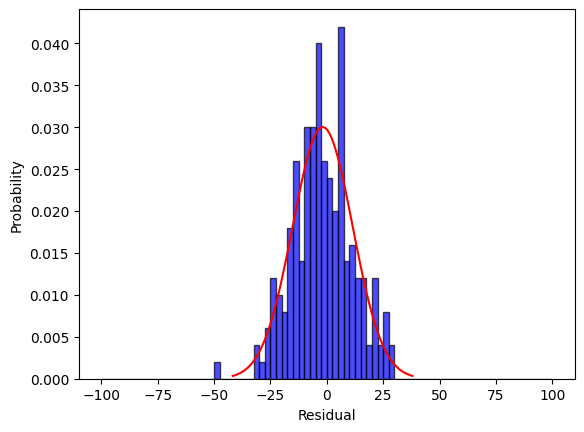

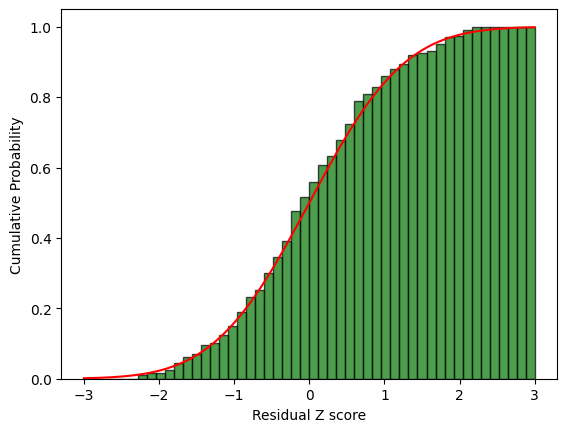

upper: 24.742860350507293, lower: -28.396891962590573, score: 8.598779650536434, Structural Change has been detected

Error at index 526, daily price: 809.0924204088393

Online learning...

upper: 24.742860350507293, lower: -28.396891962590573, score: 8.480822412344134, Structural Change has been detected

Error at index 807, daily price: 695.0063473314576

['model_526.pkl', 'model_807.pkl']
All files and subdirectories deleted successfully.


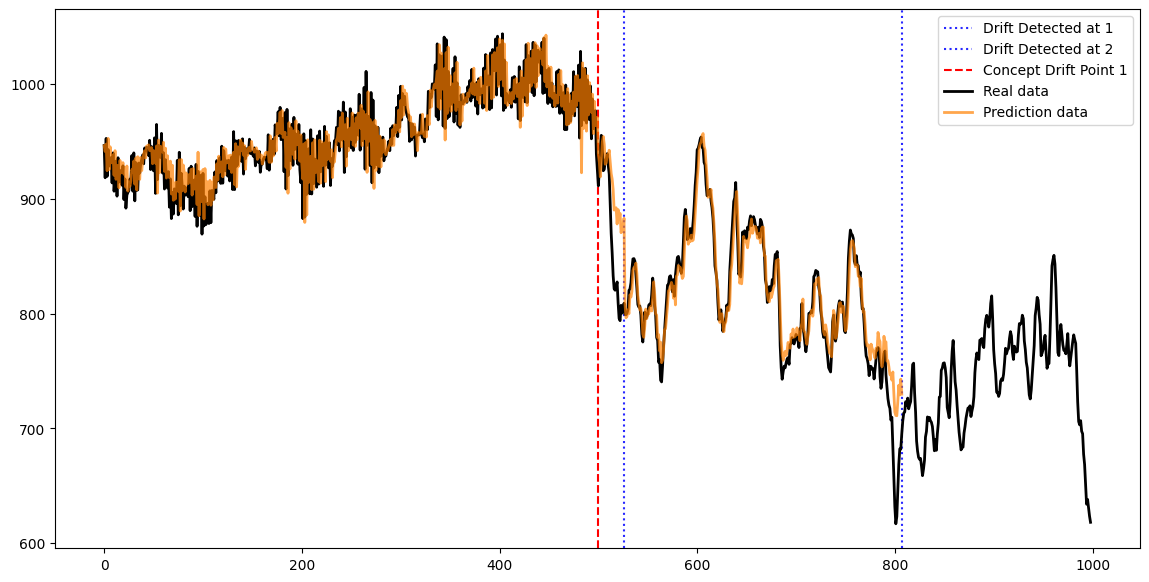

-------------------------------------------index = 1----------------------------------------------
Random number  3845329292
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3845329292, RMSE = 13.902295544965991
Residual AVG = -3.1437602611979, Residual STD = 13.54217829005711
MAPE = 193.27382141958125
R2 score = 0.2564781121594186, Adjusted R2 score 0.20850895810518755
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3845329292, RMSE = 12.595073245823576
Residual AVG = -1.2628132835624195, Residual STD = 12.531606947176373
MAPE = 158.63587006766085
R2 score = 0.4466437940759256, Adjusted R2 score 0.41094339369372723
RMSE AVG = 13.248684395394783, RMSE STD = 0.6536111495712076
Residual AVG = -2.2032867723801597, Residual STD = 13.080534130618506
one sigma percent: 0.705, two sigma percent: 0.965, three sigma percent: 0.995


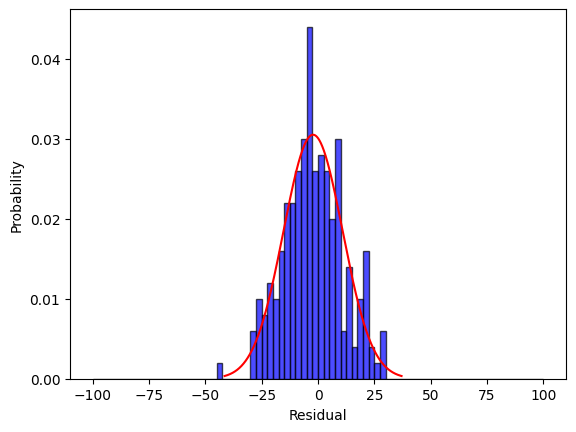

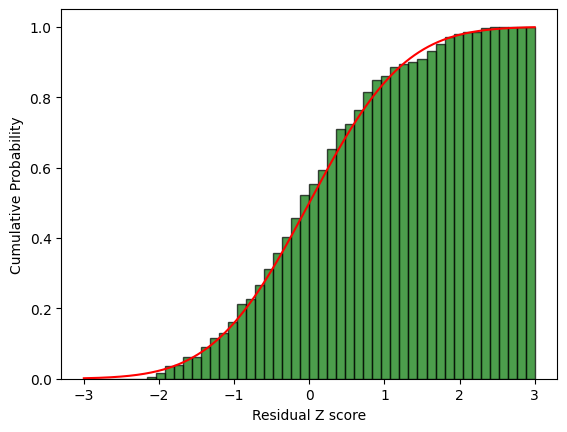

upper: 23.957781488856853, lower: -28.364355033617173, score: 8.570667846758766, Structural Change has been detected

Error at index 526, daily price: 809.0924204088393

Online learning...

upper: 23.957781488856853, lower: -28.364355033617173, score: 8.503255466747824, Structural Change has been detected

Error at index 830, daily price: 672.2077107387667

['model_526.pkl', 'model_830.pkl']
All files and subdirectories deleted successfully.


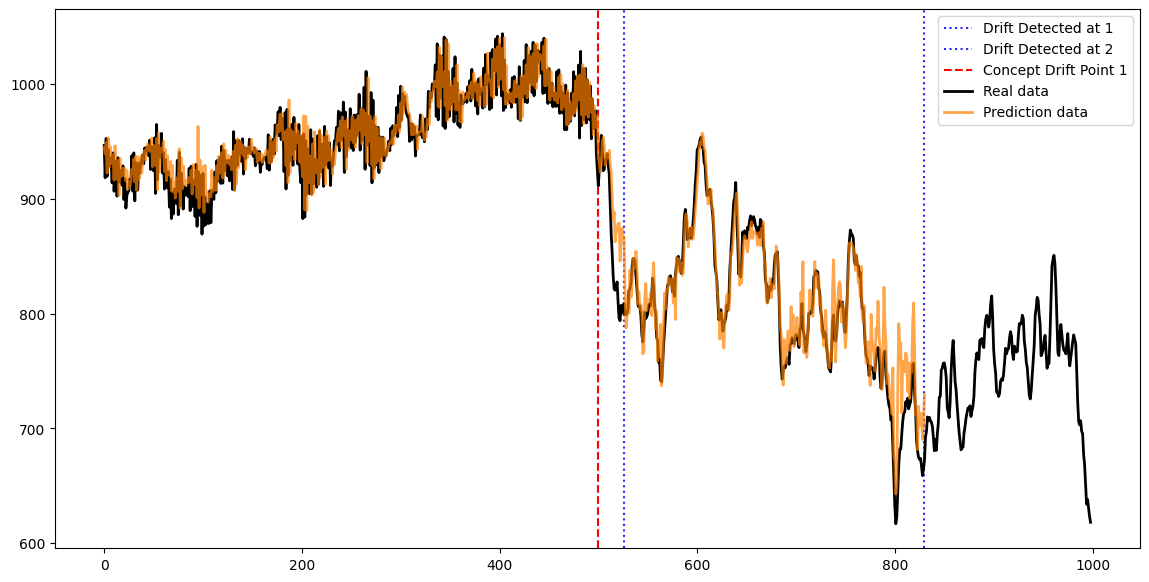

-------------------------------------------index = 2----------------------------------------------
Random number  1274958824
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 1274958824, RMSE = 13.569732912607446
Residual AVG = -2.9831011270106593, Residual STD = 13.237777720808335
MAPE = 184.13765131950177
R2 score = 0.29162484020851565, Adjusted R2 score 0.24592321699616182
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 1274958824, RMSE = 12.607015486205322
Residual AVG = -1.6634256371729714, Residual STD = 12.496793773565141
MAPE = 158.93683946942082
R2 score = 0.44559394774428496, Adjusted R2 score 0.4098258153406904
RMSE AVG = 13.088374199406385, RMSE STD = 0.48135871320106194
Residual AVG = -2.3232633820918154, Residual STD = 12.889518712965687
one sigma percent: 0.7, two sigma percent: 0.95, three sigma percent: 0.995


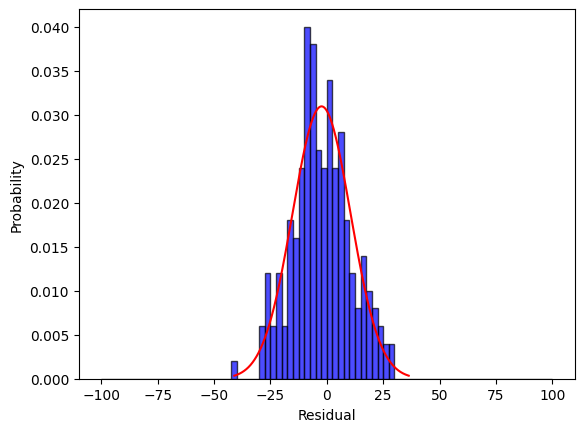

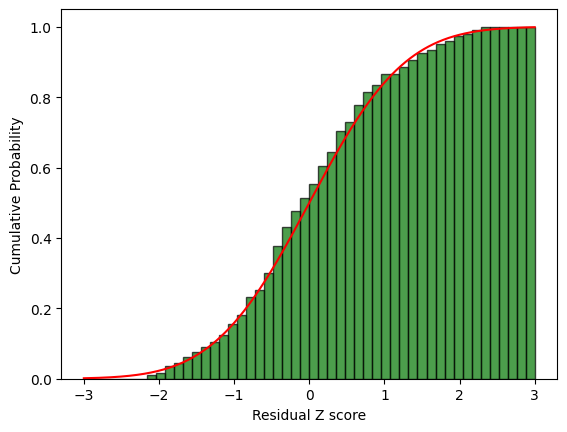

upper: 23.455774043839558, lower: -28.10230080802319, score: 8.443198401965699, Structural Change has been detected

Error at index 527, daily price: 799.500629137161

Online learning...

upper: 23.455774043839558, lower: -28.10230080802319, score: 8.504313658520939, Structural Change has been detected

Error at index 804, daily price: 668.5391993199136

['model_527.pkl', 'model_804.pkl']
All files and subdirectories deleted successfully.


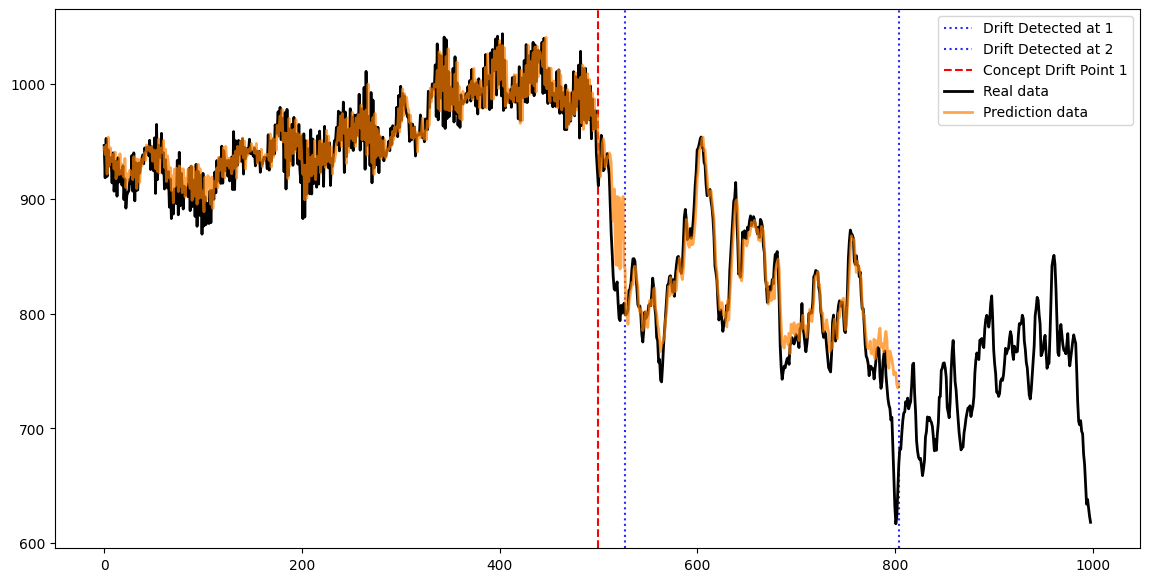

-------------------------------------------index = 3----------------------------------------------
Random number  2363023211
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 2363023211, RMSE = 13.538657760019118
Residual AVG = -2.3379643695931405, Residual STD = 13.335260647975307
MAPE = 183.29525394292588
R2 score = 0.29486553200600407, Adjusted R2 score 0.24937298568381072
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 2363023211, RMSE = 13.262278678003359
Residual AVG = -1.2339395188908975, Residual STD = 13.204750243633608
MAPE = 175.8880357330225
R2 score = 0.3864645109636866, Adjusted R2 score 0.3468815761871502
RMSE AVG = 13.400468219011238, RMSE STD = 0.13818954100787995
Residual AVG = -1.785951944242019, Residual STD = 13.281642236215834
one sigma percent: 0.68, two sigma percent: 0.945, three sigma percent: 1.0


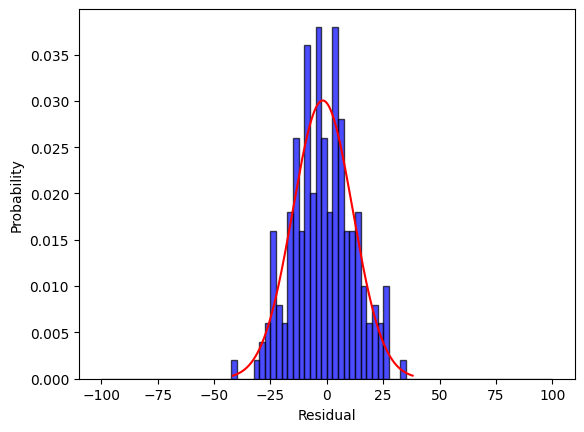

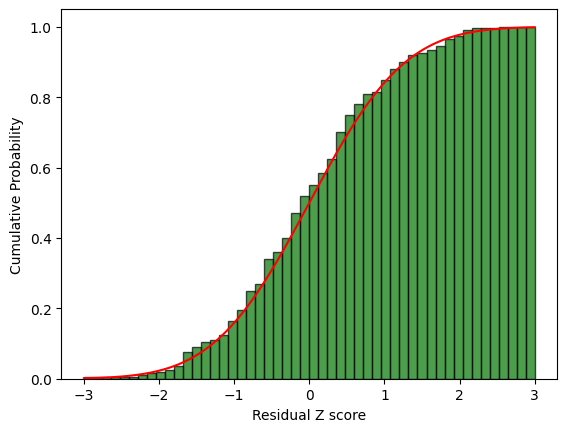

upper: 24.77733252818965, lower: -28.349236416673687, score: 8.579641237856027, Structural Change has been detected

Error at index 526, daily price: 809.0924204088393

Online learning...

upper: 24.77733252818965, lower: -28.349236416673687, score: 8.563097745343429, Structural Change has been detected

Error at index 802, daily price: 623.1486377463535

['model_526.pkl', 'model_802.pkl']
All files and subdirectories deleted successfully.


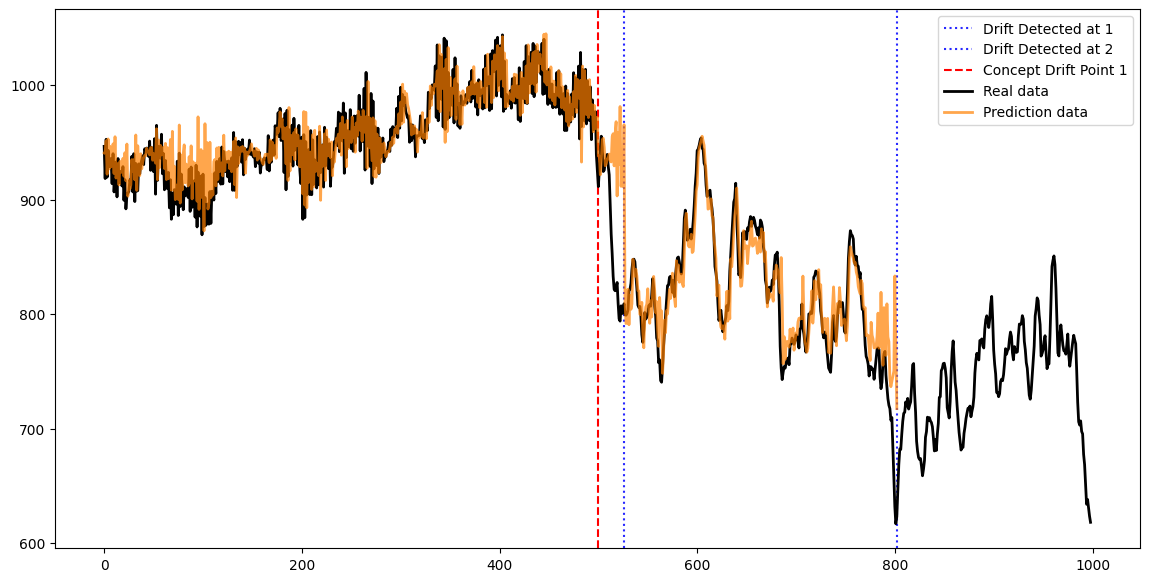

-------------------------------------------index = 4----------------------------------------------
Random number  3675353687
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3675353687, RMSE = 13.461587117195066
Residual AVG = -2.356397380336314, Residual STD = 13.253743588125442
MAPE = 181.21432771383215
R2 score = 0.30287082825848455, Adjusted R2 score 0.2578947526622577
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3675353687, RMSE = 12.709954734277652
Residual AVG = -0.7540948942888406, Residual STD = 12.687564393444253
MAPE = 161.5429493473869
R2 score = 0.436503273146683, Adjusted R2 score 0.4001486456077593
RMSE AVG = 13.085770925736359, RMSE STD = 0.37581619145870704
Residual AVG = -1.5552461373125772, Residual STD = 12.998455599915854
one sigma percent: 0.69, two sigma percent: 0.96, three sigma percent: 0.995


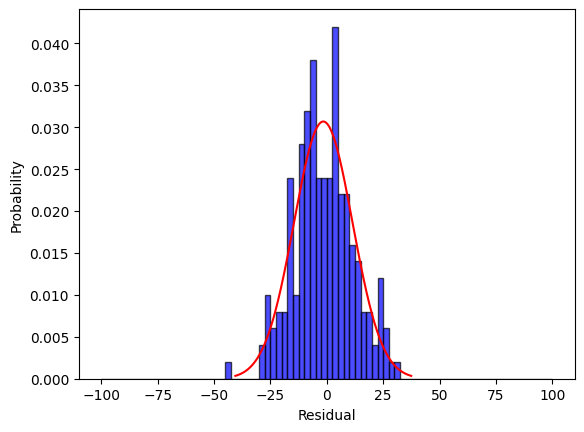

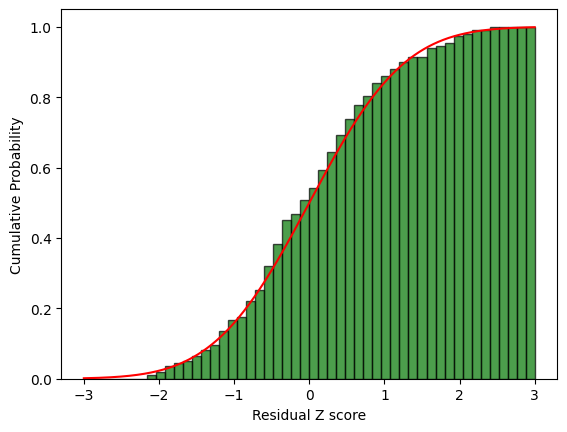

upper: 24.44166506251913, lower: -27.552157337144283, score: 8.479707557883515, Structural Change has been detected

Error at index 527, daily price: 799.500629137161

Online learning...

['model_527.pkl']
All files and subdirectories deleted successfully.


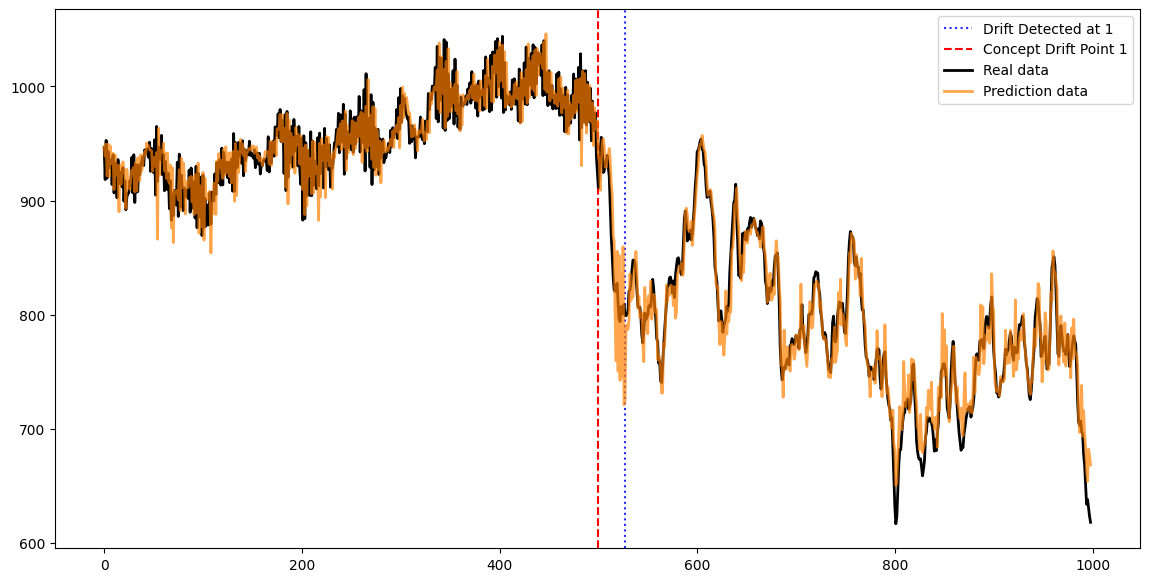

-------------------------------------------index = 5----------------------------------------------
Random number  3788362590
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3788362590, RMSE = 13.144113330662869
Residual AVG = -2.822206796930553, Residual STD = 12.837556778634646
MAPE = 172.76771524930933
R2 score = 0.3353648370143103, Adjusted R2 score 0.29248514907974965
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3788362590, RMSE = 12.969402191884763
Residual AVG = -1.300501962948514, Residual STD = 12.90403378247408
MAPE = 168.2053932148653
R2 score = 0.41326322876631993, Adjusted R2 score 0.37540924352543736
RMSE AVG = 13.056757761273815, RMSE STD = 0.08735556938905287
Residual AVG = -2.0613543799395337, Residual STD = 12.89330726975788
one sigma percent: 0.705, two sigma percent: 0.96, three sigma percent: 0.995


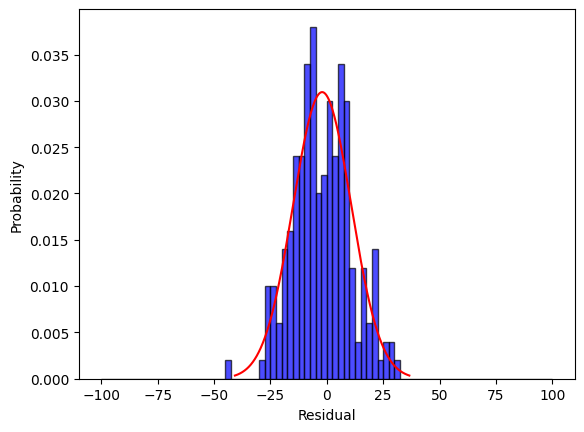

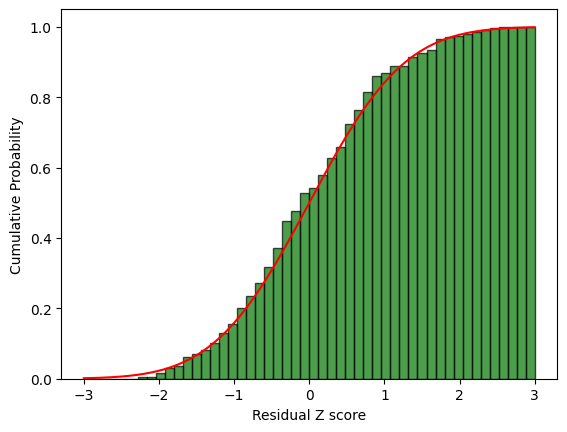

upper: 23.725260159576226, lower: -27.847968919455294, score: 8.570594680836205, Structural Change has been detected

Error at index 546, daily price: 786.0711363683947

Online learning...

['model_546.pkl']
All files and subdirectories deleted successfully.


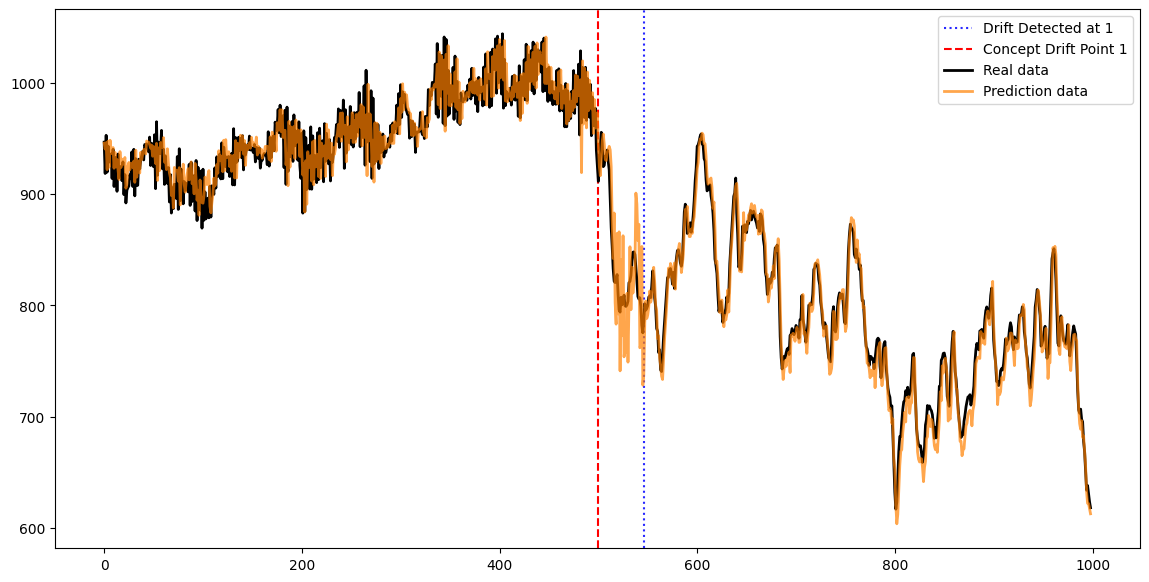

-------------------------------------------index = 6----------------------------------------------
Random number  3627027762
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3627027762, RMSE = 13.909604275968972
Residual AVG = -2.4237576674049945, Residual STD = 13.696805827774218
MAPE = 193.4770911140543
R2 score = 0.2556961362774016, Adjusted R2 score 0.20767653216626625
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3627027762, RMSE = 12.495194380706089
Residual AVG = -0.8419245010024292, Residual STD = 12.466797734231548
MAPE = 156.12988261162903
R2 score = 0.45538522002310655, Adjusted R2 score 0.42024878260524245
RMSE AVG = 13.202399328337531, RMSE STD = 0.7072049476314418
Residual AVG = -1.6328410842037118, Residual STD = 13.120111160221857
one sigma percent: 0.71, two sigma percent: 0.945, three sigma percent: 0.995


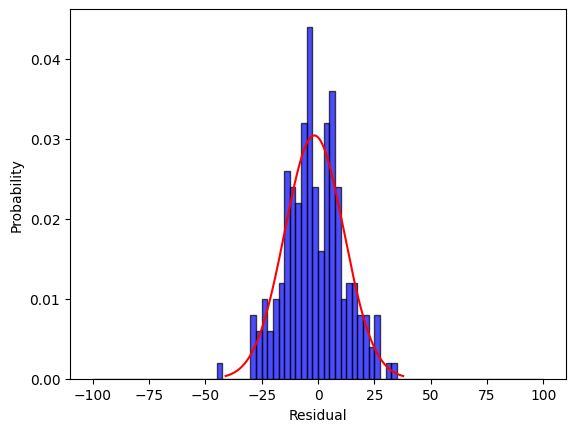

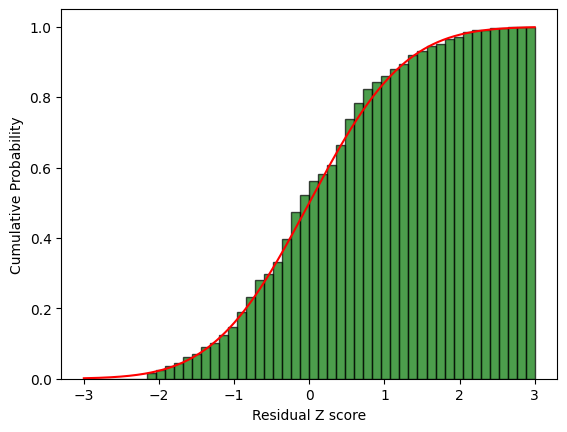

upper: 24.607381236240002, lower: -27.873063404647425, score: 8.531645954090436, Structural Change has been detected

Error at index 801, daily price: 616.8728534701531

Online learning...

['model_801.pkl']
All files and subdirectories deleted successfully.


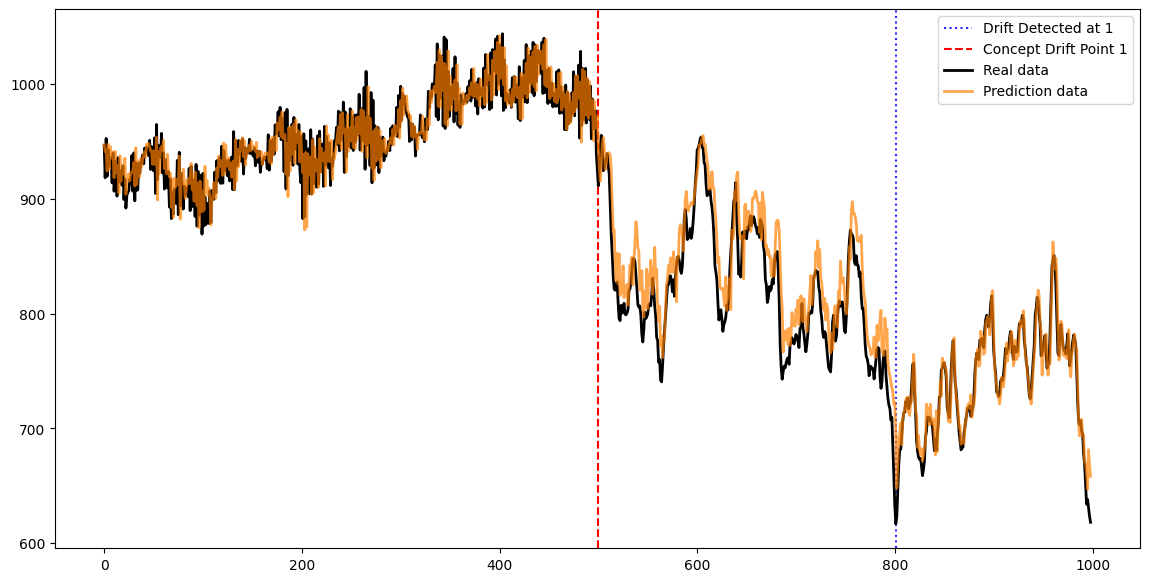

-------------------------------------------index = 7----------------------------------------------
Random number  2823819716
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 2823819716, RMSE = 13.37177461334178
Residual AVG = -2.235239061621903, Residual STD = 13.1836285842484
MAPE = 178.8043563100117
R2 score = 0.3121419570365531, Adjusted R2 score 0.2677640187808469
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 2823819716, RMSE = 12.768431371646937
Residual AVG = -0.8546566477964472, Residual STD = 12.73979598372105
MAPE = 163.03283969245766
R2 score = 0.4313062135646375, Adjusted R2 score 0.39461629185913016
RMSE AVG = 13.070102992494359, RMSE STD = 0.3016716208474213
Residual AVG = -1.5449478547091753, Residual STD = 12.981977281118015
one sigma percent: 0.7, two sigma percent: 0.96, three sigma percent: 0.995


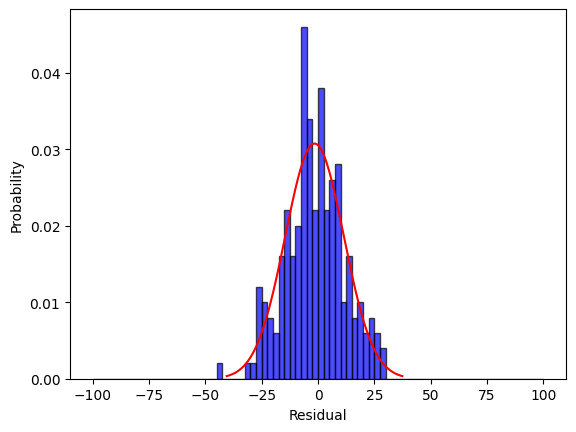

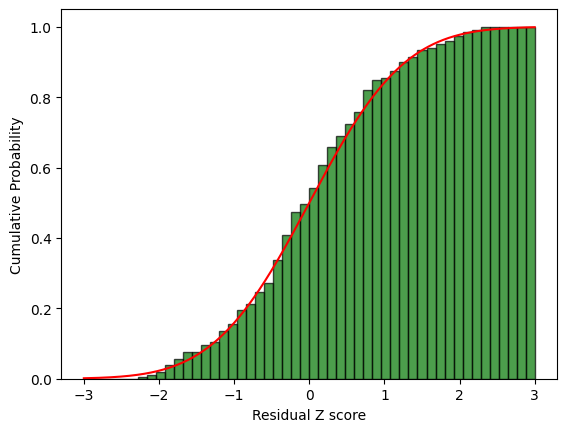

upper: 24.419006707526854, lower: -27.508902416945205, score: 8.469717312263306, Structural Change has been detected

Error at index 635, daily price: 865.7532303827378

Online learning...

upper: 24.419006707526854, lower: -27.508902416945205, score: 8.605033639992904, Structural Change has been detected

Error at index 810, daily price: 714.275454653363

['model_635.pkl', 'model_810.pkl']
All files and subdirectories deleted successfully.


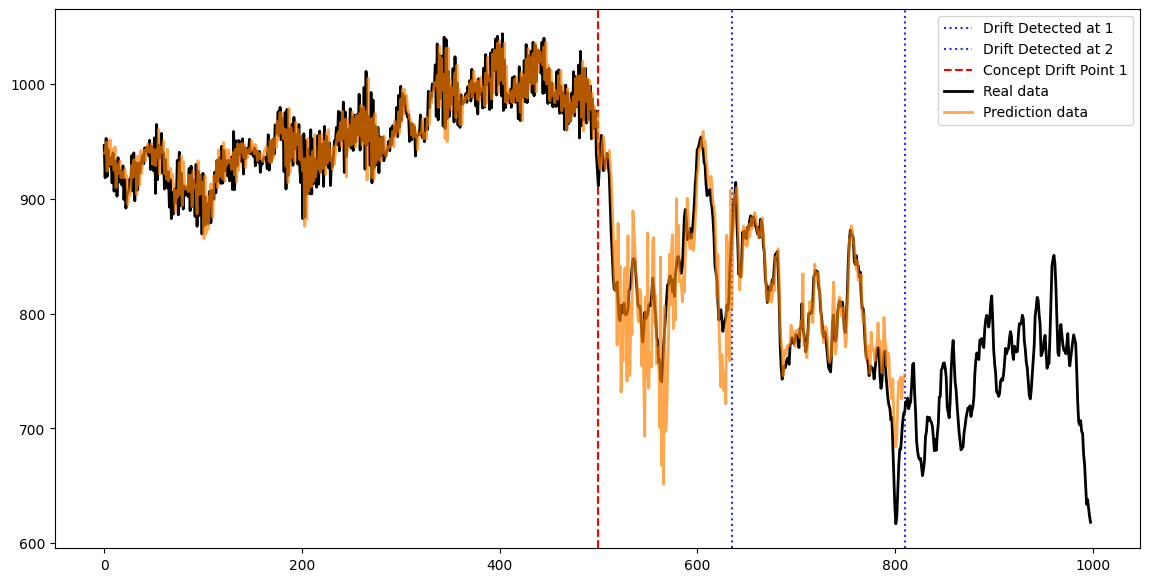

-------------------------------------------index = 8----------------------------------------------
Random number  3576474609
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3576474609, RMSE = 13.3384240356785
Residual AVG = -2.1638263996506883, Residual STD = 13.161740427000554
MAPE = 177.91355575556594
R2 score = 0.3155688552324195, Adjusted R2 score 0.27141200718289815
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 3576474609, RMSE = 12.969073951362484
Residual AVG = -1.6520943380720745, Residual STD = 12.8634156993397
MAPE = 168.1968791559089
R2 score = 0.4132929276443802, Adjusted R2 score 0.37544085846014663
RMSE AVG = 13.153748993520491, RMSE STD = 0.18467504215800812
Residual AVG = -1.9079603688613815, Residual STD = 13.01594809019273
one sigma percent: 0.705, two sigma percent: 0.96, three sigma percent: 0.995


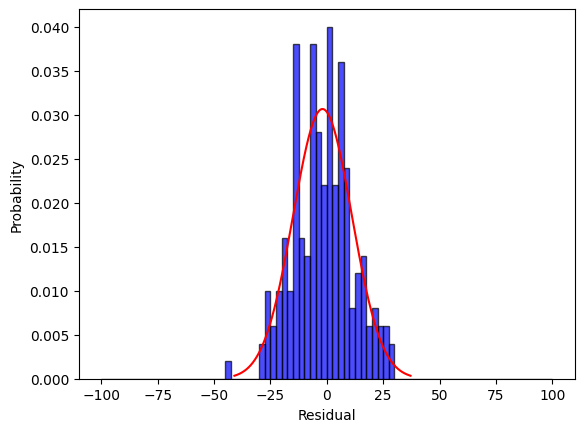

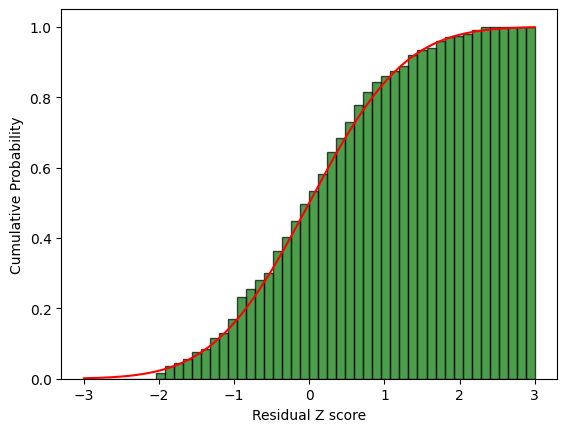

upper: 24.123935811524078, lower: -27.93985654924684, score: 8.48815729061607, Structural Change has been detected

Error at index 525, daily price: 803.2814355729328

Online learning...

upper: 24.123935811524078, lower: -27.93985654924684, score: 8.457647302604324, Structural Change has been detected

Error at index 799, daily price: 656.4667007096675

['model_525.pkl', 'model_799.pkl']
All files and subdirectories deleted successfully.


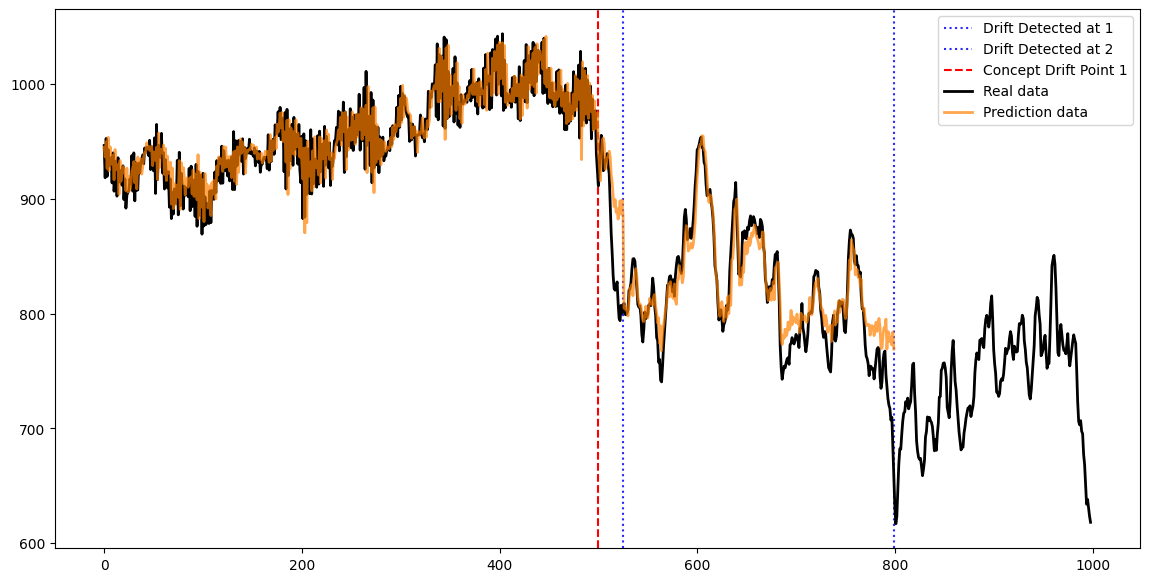

-------------------------------------------index = 9----------------------------------------------
Random number  1993383488
Number of samples for train 799 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 1993383488, RMSE = 13.181722886769746
Residual AVG = -2.1592364377907938, Residual STD = 13.003673183731811
MAPE = 173.75781826358931
R2 score = 0.3315559235415645, Adjusted R2 score 0.2884304992539235
Number of samples for train 899 and for test 100
Batch learning...

Hidden nodes: 60, Random state = 1993383488, RMSE = 12.828491730314239
Residual AVG = -1.6848376664391764, Residual STD = 12.717370880511764
MAPE = 164.5702000747408
R2 score = 0.42594356823155277, Adjusted R2 score 0.388907669407782
RMSE AVG = 13.005107308541993, RMSE STD = 0.17661557822775364
Residual AVG = -1.9220370521149852, Residual STD = 12.863505849474402
one sigma percent: 0.705, two sigma percent: 0.955, three sigma percent: 0.995


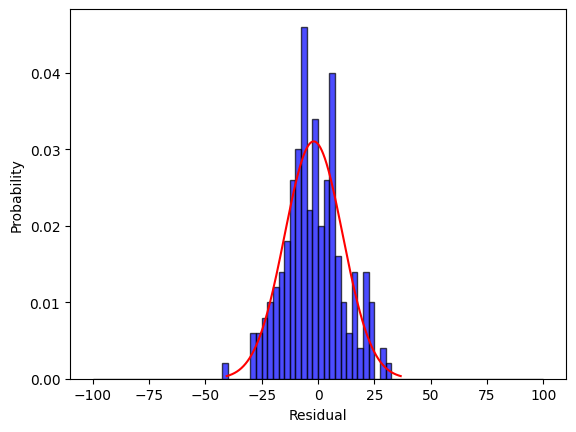

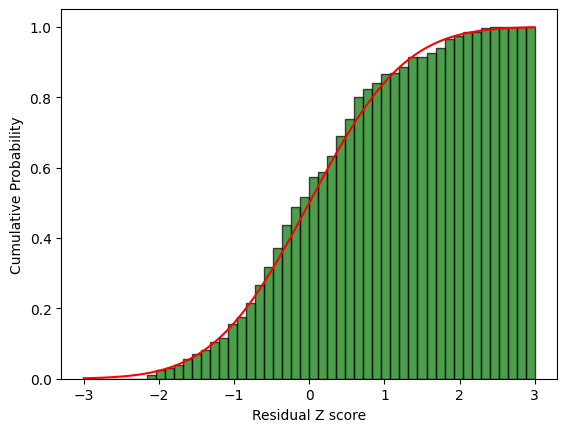

upper: 23.80497464683382, lower: -27.649048751063788, score: 8.575076531714043, Structural Change has been detected

Error at index 526, daily price: 809.0924204088393

Online learning...

upper: 23.80497464683382, lower: -27.649048751063788, score: 8.438015398960182, Structural Change has been detected

Error at index 800, daily price: 631.8977342822345

['model_526.pkl', 'model_800.pkl']
All files and subdirectories deleted successfully.


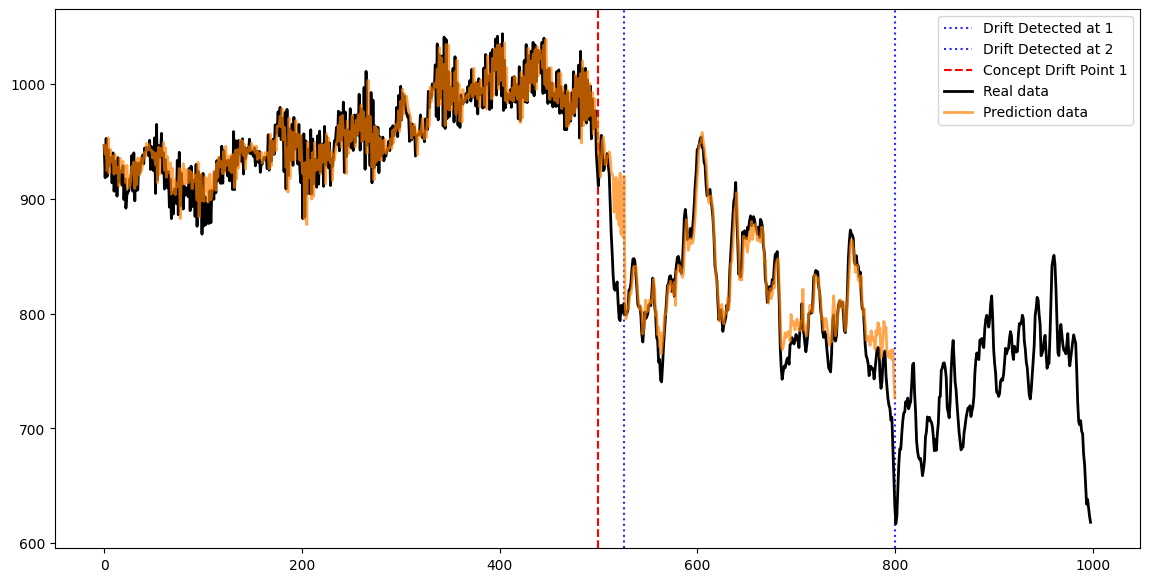

min drift point = 527 and index = 4


<Figure size 640x480 with 0 Axes>

In [50]:
import pickle
if __name__ == "__main__":
    # EDD parameters
    window_size = 100
    percent = 0.8
    nodes = 60
    decay_rate = 0.1
    drift_points = [500]
    min_dp = 1000
    min_index = 0
    for i in range(10):
        print(f"-------------------------------------------index = {i}----------------------------------------------")
        dp = EDD_sudden_drift_test(window_size, percent, nodes, decay_rate)
        # dp = DDM_sudden_drift_test(window_size, percent, nodes, decay_rate)
        if dp<min_dp:
            min_dp = dp
            min_index = i
    print(f"min drift point = {min_dp} and index = {min_index}")

In [20]:
import random
from river import drift

rng = random.Random(42)
ddm = drift.binary.DDM()

data_stream = rng.choices([0, 1], k=1000)
data_stream = data_stream + rng.choices([0, 1], k=1000, weights=[0.3, 0.7])

print_warning = True
for i, x in enumerate(data_stream):
    ddm.update(bool(x))
    if ddm.warning_detected and print_warning:
        print(f"Warning detected at index {i}")
        print_warning = False
    if ddm.drift_detected:
        print(f"Change detected at index {i}")
        print_warning = True

Warning detected at index 1084
Change detected at index 1334
Warning detected at index 1492
